In [6]:
# --- Step 1 (fixed): build Naive Bayes + KNN robustly ---
#Lab5ShubhanBhat
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional: used only if you have a text column
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

# ---- Load your spam dataset (CSV first, fallback to XLSX) ----
try:
    df = pd.read_csv("spam_dataset.csv")
except FileNotFoundError:
    df = pd.read_excel("spam.xlsx")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# ---- Find the label column safely ----
label_candidates = [c for c in df.columns if c.lower() in ("label", "spam", "target", "y", "is_spam")]
if not label_candidates:
    raise ValueError(
        "Couldn't find a label column. Rename your label to one of: "
        "'spam', 'label', 'target', 'y', 'is_spam'."
    )
label_col = label_candidates[0]

# ---- Normalize labels to integers 0/1 when possible ----
def normalize_label(v):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().lower()
    if s in {"1", "true", "yes", "spam"}:
        return 1
    if s in {"0", "false", "no", "ham"}:
        return 0
    # try numeric fallback
    try:
        return int(float(s))
    except Exception:
        return np.nan

y_series = df[label_col].apply(normalize_label)

# If still non-numeric (e.g., other strings), factorize to 0..K-1
if not np.issubdtype(y_series.dropna().dtype, np.number):
    y_series, _ = pd.factorize(df[label_col])

# Final y
y = y_series.fillna(0).astype(int).values

# ---- Build feature matrix X ----
feature_df = df.drop(columns=[label_col])

# Detect text columns (dtype=object). If present, we’ll treat them as text.
text_cols = [c for c in feature_df.columns if feature_df[c].dtype == "object" or feature_df[c].dtype == "string"]
has_text = len(text_cols) >= 1

if has_text:
    # Combine all object cols into one text field (handles 1+ text columns)
    X_text = feature_df[text_cols].astype(str).agg(" ".join, axis=1)

    # Train/test split on text
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
    )

    # NB pipeline for text: CountVectorizer -> MultinomialNB
    nb_pipe = make_pipeline(CountVectorizer(), MultinomialNB())
    nb_pipe.fit(X_train_text, y_train)
    y_pred_nb = nb_pipe.predict(X_test_text)

    # For KNN, vectorize with the same CountVectorizer and use dense arrays
    vec = nb_pipe.named_steps["countvectorizer"]
    X_train_vec = vec.transform(X_train_text)
    X_test_vec  = vec.transform(X_test_text)
    X_train_knn = X_train_vec.toarray()
    X_test_knn  = X_test_vec.toarray()

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_knn, y_train)
    y_pred_knn = knn.predict(X_test_knn)

else:
    # Numeric features path
    X_num = feature_df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    # Ensure non-negative for MultinomialNB
    min_val = float(X_num.min().min())
    if min_val < 0:
        X_nb = X_num - min_val
    else:
        X_nb = X_num.copy()

    # Train/test split for NB
    X_train_nb, X_test_nb, y_train, y_test = train_test_split(
        X_nb, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
    )

    nb = MultinomialNB()
    nb.fit(X_train_nb, y_train)
    y_pred_nb = nb.predict(X_test_nb)

    # KNN: scale numeric features to [0, 1]
    scaler = MinMaxScaler()
    X_knn = scaler.fit_transform(X_num)
    X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
        X_knn, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
    )
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_knn, y_train_knn)
    y_pred_knn = knn.predict(X_test_knn)

# ---- Metrics ----
print("\nNaive Bayes\n-----------")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

print("\nKNN (k=5)\n---------")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


Dataset shape: (50, 5)
Columns: ['word1', 'word2', 'word3', 'word4', 'spam']


,word1,word2,word3,word4,spam
0,0,0,0,0,0
1,1,1,1,0,1
2,0,0,1,0,0
3,0,1,1,0,0
4,0,0,1,0,1



Naive Bayes
-----------
Accuracy: 0.26666666666666666
Confusion Matrix:
 [[3 5]
 [6 1]]
              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.17      0.14      0.15         7

    accuracy                           0.27        15
   macro avg       0.25      0.26      0.25        15
weighted avg       0.26      0.27      0.26        15


KNN (k=5)
---------
Accuracy: 0.3333333333333333
Confusion Matrix:
 [[1 7]
 [3 4]]
              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.36      0.57      0.44         7

    accuracy                           0.33        15
   macro avg       0.31      0.35      0.31        15
weighted avg       0.30      0.33      0.30        15



In [7]:
# -----------------------------
# 1) Load your CSV
# -----------------------------
CSV_PATH = Path("spam_dataset.csv")  # adjust if needed
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH.resolve())
display(df.head())

Loaded: /var/www/filebrowser/.projects/1c14160c-ad07-4c97-9873-dad55c632c0d/spam_dataset.csv


,word1,word2,word3,word4,spam
0,0,0,0,0,0
1,1,1,1,0,1
2,0,0,1,0,0
3,0,1,1,0,0
4,0,0,1,0,1


Columns: ['ID', 'Prediction', 'True_Label', 'Unnamed: 3', 'student ID', 'student Name', 'index', 'threshold', 'TPR', 'FPR']


,ID,Prediction,True_Label,Unnamed: 3,student ID,student Name,index,threshold,TPR,FPR
0,1,0.998,1,NaN,1.0,Christine,8.0,NaN,0.125000,0.000000
1,2,0.998,1,NaN,2.0,Adam Abril,16.0,0.986,0.208333,0.012821
2,3,0.998,1,NaN,3.0,thaddeus :),24.0,0.979,0.305556,0.012821
3,4,0.997,1,NaN,4.0,Shajan,32.0,0.970,NaN,NaN
4,5,0.997,1,NaN,5.0,Serena,40.0,0.997,0.513800,0.038400


,Threshold,TP,FP,TN,FN,TPR,FPR
0,0.2,70,26,52,2,0.972,0.333
1,0.5,67,11,67,5,0.931,0.141
2,0.8,54,5,73,18,0.750,0.064


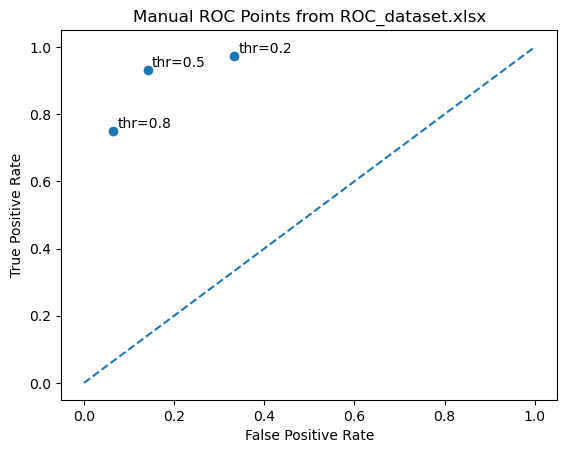

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
#Task 2a part 1/2

# --- Load ROC dataset (make sure ROC_dataset.xlsx is in same folder as your notebook) ---
df_roc = pd.read_excel("ROC_dataset.xlsx")

print("Columns:", df_roc.columns.tolist())
display(df_roc.head())

# --- Explicitly use the right columns ---
y_true = df_roc["True_Label"].astype(int).values
y_score = pd.to_numeric(df_roc["Prediction"], errors="coerce").fillna(0.0).values

def tpr_fpr_from_threshold(y_true, y_score, thr):
    """Return confusion matrix + TPR/FPR at a given threshold."""
    y_pred = (y_score >= thr).astype(int)
    TP = int(((y_true == 1) & (y_pred == 1)).sum())
    FP = int(((y_true == 0) & (y_pred == 1)).sum())
    TN = int(((y_true == 0) & (y_pred == 0)).sum())
    FN = int(((y_true == 1) & (y_pred == 0)).sum())
    TPR = TP / (TP + FN) if (TP + FN) else 0
    FPR = FP / (FP + TN) if (FP + TN) else 0
    return TP, FP, TN, FN, TPR, FPR

# --- Example thresholds (replace with your assigned one) ---
thresholds = [0.2, 0.5, 0.8]
rows = []
for thr in thresholds:
    TP, FP, TN, FN, TPR, FPR = tpr_fpr_from_threshold(y_true, y_score, thr)
    rows.append({
        "Threshold": thr, "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "TPR": round(TPR, 3), "FPR": round(FPR, 3)
    })

manual_roc = pd.DataFrame(rows)
display(manual_roc)

# --- Plot ROC points ---
plt.figure()
plt.scatter(manual_roc["FPR"], manual_roc["TPR"])
for _, r in manual_roc.iterrows():
    plt.text(r["FPR"]+0.01, r["TPR"]+0.01, f"thr={r['Threshold']}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Manual ROC Points from ROC_dataset.xlsx")
plt.show()



Confusion Matrix at threshold=0.5:
 [[67 11]
 [ 5 67]]


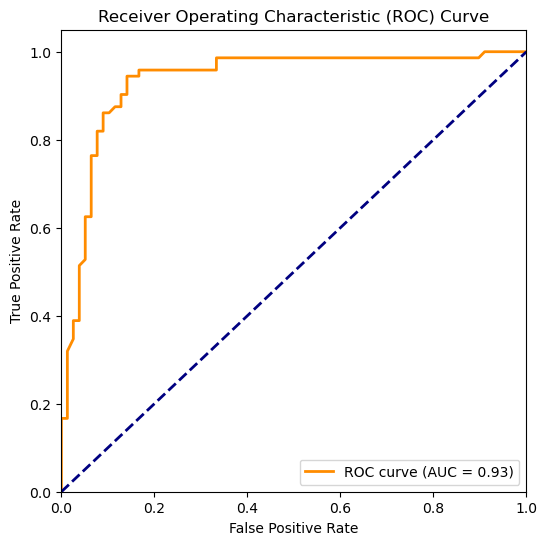

ROC AUC Score: 0.934


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
#Task 2a part 3
# --- Load ROC dataset ---
df_roc = pd.read_excel("ROC_dataset.xlsx")

# Make sure the right columns are selected
y_true = df_roc["True_Label"].astype(int).values
y_score = pd.to_numeric(df_roc["Prediction"], errors="coerce").fillna(0.0).values

# --- Step 1: Confusion Matrix at threshold = 0.5 (example) ---
threshold = 0.5
y_pred = (y_score >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix at threshold={threshold}:\n", cm)

# --- Step 2: ROC curve points (all thresholds) ---
fpr, tpr, thr = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# --- Step 3: Plot ROC curve ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print("ROC AUC Score:", round(roc_auc, 3))


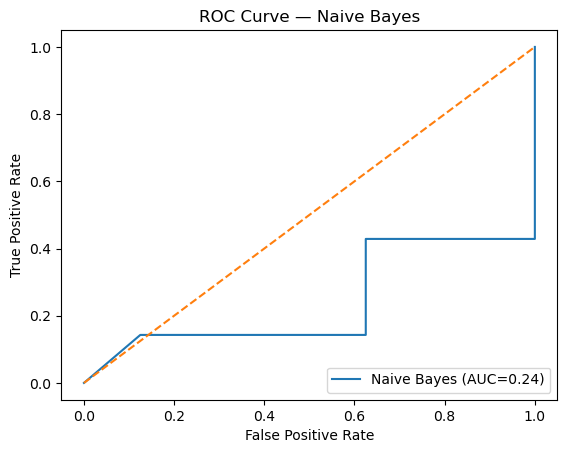

Naive Bayes AUC: 0.2411


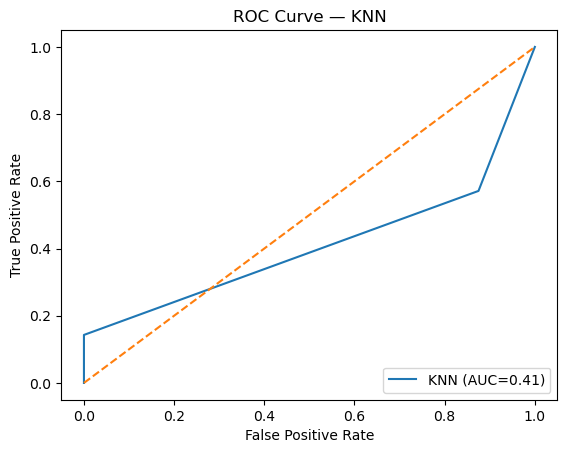

KNN AUC: 0.4107


In [8]:
from sklearn.metrics import roc_curve, auc
#Task 2b
# --- Ensure labels are 0/1 ---
y_unique = np.unique(y_train)
if set(y_unique) != {0, 1}:
    mapping = {val: idx for idx, val in enumerate(sorted(y_unique))}
    y_test_bin = np.vectorize(mapping.get)(y_test)
else:
    y_test_bin = y_test

# --- Naive Bayes ROC ---
if hasattr(nb, "predict_proba"):
    y_score_nb = nb.predict_proba(X_test_nb)[:, 1]  # X_test_nb from Step 1b
    fpr_nb, tpr_nb, _ = roc_curve(y_test_bin, y_score_nb, pos_label=1)
    auc_nb = auc(fpr_nb, tpr_nb)

    plt.figure()
    plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC={auc_nb:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Naive Bayes")
    plt.legend(loc="lower right")
    plt.show()

    print("Naive Bayes AUC:", round(auc_nb, 4))

# --- KNN ROC ---
if hasattr(knn, "predict_proba"):
    y_score_knn = knn.predict_proba(X_test_knn)[:, 1]  # X_test_knn from Step 1b
    fpr_knn, tpr_knn, _ = roc_curve(y_test_bin, y_score_knn, pos_label=1)
    auc_knn = auc(fpr_knn, tpr_knn)

    plt.figure()
    plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC={auc_knn:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — KNN")
    plt.legend(loc="lower right")
    plt.show()

    print("KNN AUC:", round(auc_knn, 4))


In [37]:
# detect if dataset is *text* (has a likely text column) or *tabular* (numeric features)
#Extra step 2 task
text_candidates = [c for c in df.columns if c.lower() in {"text", "message", "sms", "email", "content", "body"}]
has_text = len(text_candidates) > 0

print(f"Label column: {label_col}")
print("Detected text dataset?" , has_text)

Label column: spam
Detected text dataset? False


In [38]:
# -----------------------------
# 3) Prepare X, y
# -----------------------------
def normalize_label(v):
    s = str(v).strip().lower()
    if s in {"spam", "1", "true", "yes"}:
        return 1
    if s in {"ham", "0", "false", "no"}:
        return 0
    try:
        return int(float(s))
    except:
        return s

In [39]:
y = df[label_col].map(normalize_label)
if not np.issubdtype(y.dtype, np.number):
    y, _ = pd.factorize(y)  # 0..K-1

if has_text:
    text_col = text_candidates[0]
    X_raw = df[text_col].astype(str).fillna("")
else:
    X_raw = df.drop(columns=[label_col])
    # ensure numeric & non-negative for MultinomialNB
    X_raw = X_raw.apply(pd.to_numeric, errors="coerce").fillna(0.0)

In [40]:
# quick sanity
print("Class distribution:", pd.Series(y).value_counts().to_dict())

# -----------------------------
# 4) Train/test split
# -----------------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

Class distribution: {0: 26, 1: 24}


In [41]:
# -----------------------------
# 5) Build pipelines
# -----------------------------
if has_text:
    # Naive Bayes: TF-IDF -> MultinomialNB (good for text)
    nb_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2)),
        ("nb", MultinomialNB())  # you can try ComplementNB() too
    ])

    # KNN: TF-IDF -> SVD (reduce dims) -> KNN (KNN needs dense + smaller dims)
    knn_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2)),
        ("svd", TruncatedSVD(n_components=300, random_state=42)),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ])
else:
    # Tabular features (counts like word1…word4)
    # Naive Bayes: Multinomial if non-negative, else Gaussian
    if (X_train_raw.values >= 0).all():
        nb_model = MultinomialNB()  # try ComplementNB() if class imbalance
    else:
        nb_model = GaussianNB()

    nb_pipe = Pipeline([
        # no scaling for MultinomialNB (requires non-negative counts)
        ("nb", nb_model)
    ])

    # KNN benefits from scaling
    knn_pipe = Pipeline([
        ("scale", MinMaxScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ])


In [42]:
# -----------------------------
# 6) Fit & evaluate
# -----------------------------
nb_pipe.fit(X_train_raw, y_train)
knn_pipe.fit(X_train_raw, y_train)

def evaluate(name, model, X_tr, y_tr, X_te, y_te):
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)
    print(f"\n{name} — Train Acc: {accuracy_score(y_tr, y_tr_pred):.4f} | Test Acc: {accuracy_score(y_te, y_te_pred):.4f}")
    print(f"{name} Classification Report (Test):")
    print(classification_report(y_te, y_te_pred, digits=4, zero_division=0))
    cm = confusion_matrix(y_te, y_te_pred)
    # plot a simple confusion matrix (one figure per chart; default colors; no style)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{name} Confusion Matrix (Test)")
    plt.colorbar()
    ticks = np.arange(cm.shape[0])
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()


Naive Bayes — Train Acc: 0.5000 | Test Acc: 0.5000
Naive Bayes Classification Report (Test):
              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667         5
           1     0.0000    0.0000    0.0000         5

    accuracy                         0.5000        10
   macro avg     0.2500    0.5000    0.3333        10
weighted avg     0.2500    0.5000    0.3333        10



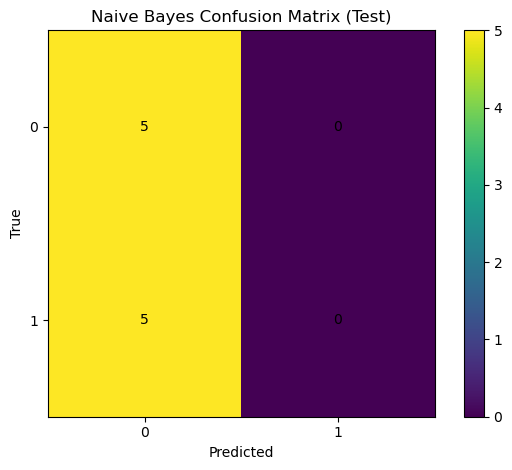


KNN (k=5) — Train Acc: 0.5750 | Test Acc: 0.4000
KNN (k=5) Classification Report (Test):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.4444    0.8000    0.5714         5

    accuracy                         0.4000        10
   macro avg     0.2222    0.4000    0.2857        10
weighted avg     0.2222    0.4000    0.2857        10



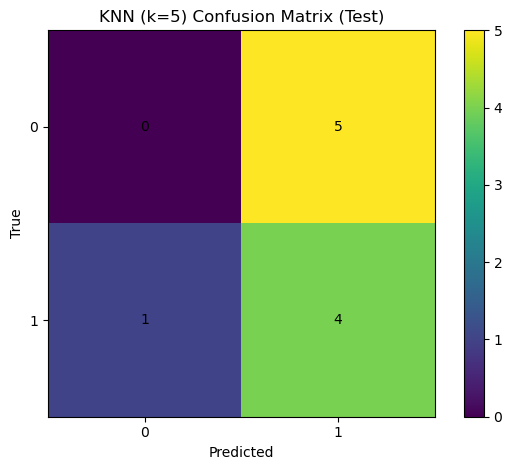


5-fold CV accuracy — NB: 0.48 ± 0.0748
5-fold CV accuracy — KNN: 0.34 ± 0.1356


In [43]:
evaluate("Naive Bayes", nb_pipe, X_train_raw, y_train, X_test_raw, y_test)
evaluate("KNN (k=5)", knn_pipe, X_train_raw, y_train, X_test_raw, y_test)

# -----------------------------
# 7) Optional: quick cross-validation
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nb_cv = cross_val_score(nb_pipe, X_raw, y, cv=cv, scoring="accuracy")
knn_cv = cross_val_score(knn_pipe, X_raw, y, cv=cv, scoring="accuracy")
print("\n5-fold CV accuracy — NB:", nb_cv.mean().round(4), "±", nb_cv.std().round(4))
print("5-fold CV accuracy — KNN:", knn_cv.mean().round(4), "±", knn_cv.std().round(4))

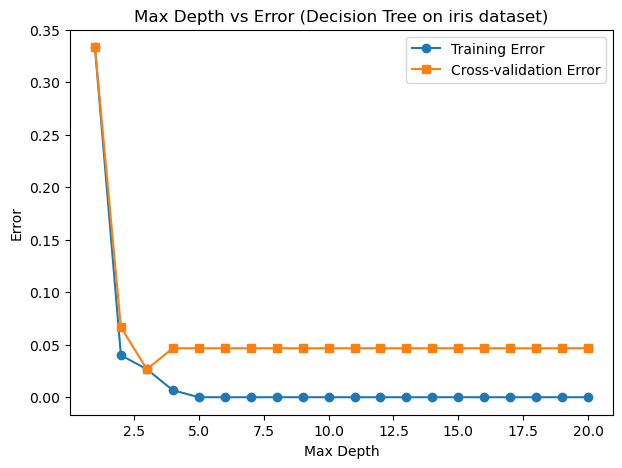

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
#Step 3a and 3b
# --- Load iris dataset ---
iris = load_iris()
X, y = iris.data, iris.target

# --- Try multiple depths ---
depths = range(1, 21)
train_errors = []
cv_errors = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X, y)
    
    # Training error (1 - accuracy on training set)
    train_acc = accuracy_score(y, clf.predict(X))
    train_errors.append(1 - train_acc)
    
    # Cross-validation error (1 - mean CV accuracy)
    cv_scores = cross_val_score(clf, X, y, cv=5)
    cv_errors.append(1 - np.mean(cv_scores))

# --- Plot Training vs Cross-validation error ---
plt.figure(figsize=(7,5))
plt.plot(depths, train_errors, marker="o", label="Training Error")
plt.plot(depths, cv_errors, marker="s", label="Cross-validation Error")
plt.xlabel("Max Depth")
plt.ylabel("Error")
plt.title("Max Depth vs Error (Decision Tree on iris dataset)")
plt.legend()
plt.show()


In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pandas as pd

# --- Load dataset (spam_dataset.csv or spam.xlsx) ---
try:
    df = pd.read_csv("spam_dataset.csv")
except FileNotFoundError:
    df = pd.read_excel("spam.xlsx")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# --- Identify label + features ---
label_col = [c for c in df.columns if c.lower() in ("label", "spam", "target", "y")][0]
X = df.drop(columns=[label_col]).apply(pd.to_numeric, errors="coerce").fillna(0.0)
y = df[label_col].astype(int).values

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Decision Tree (instead of Naive Bayes) ---
dt = DecisionTreeClassifier(max_depth=5, random_state=42)  # limit depth to reduce overfitting
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\nDecision Tree Results")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))



Dataset shape: (50, 5)
Columns: ['word1', 'word2', 'word3', 'word4', 'spam']


,word1,word2,word3,word4,spam
0,0,0,0,0,0
1,1,1,1,0,1
2,0,0,1,0,0
3,0,1,1,0,0
4,0,0,1,0,1



Decision Tree Results
Accuracy: 0.3333333333333333
Confusion Matrix:
 [[4 4]
 [6 1]]
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         8
           1       0.20      0.14      0.17         7

    accuracy                           0.33        15
   macro avg       0.30      0.32      0.31        15
weighted avg       0.31      0.33      0.31        15



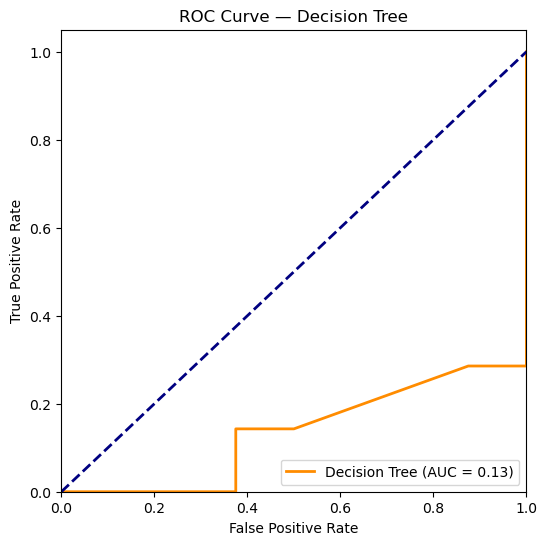

Decision Tree AUC Score: 0.134


In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Predict probabilities ---
y_score_dt = dt.predict_proba(X_test)[:, 1]

# --- ROC points ---
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# --- Plot ROC ---
plt.figure(figsize=(6,6))
plt.plot(fpr_dt, tpr_dt, color="darkorange", lw=2,
         label=f"Decision Tree (AUC = {roc_auc_dt:.2f})")
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Decision Tree")
plt.legend(loc="lower right")
plt.show()

print("Decision Tree AUC Score:", round(roc_auc_dt, 3))


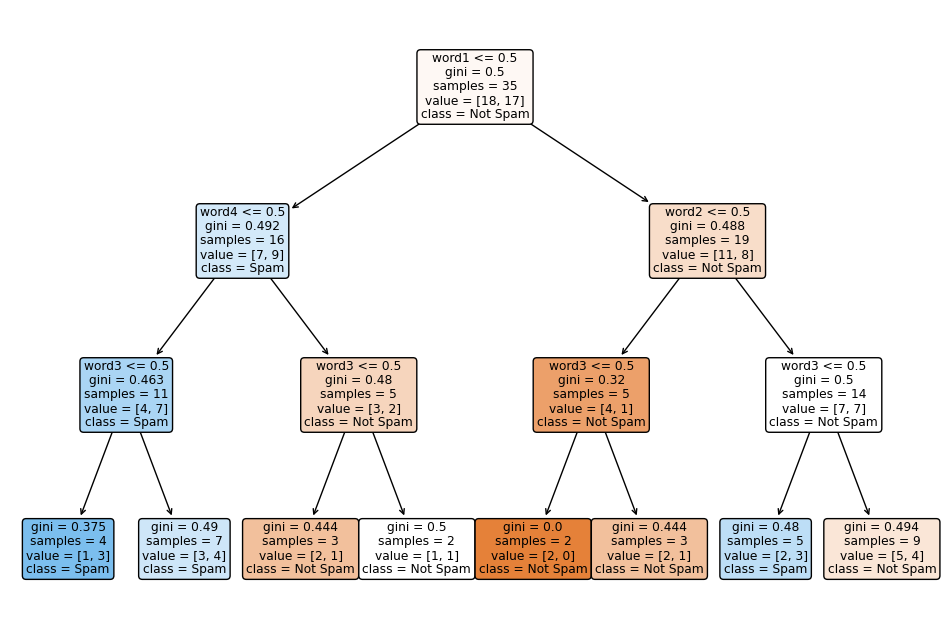

In [47]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
#For Task 1b
# Train Decision Tree (example)
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# --- Plot tree ---
plt.figure(figsize=(12,8))
tree.plot_tree(dt, 
               feature_names=list(X.columns),   # FIXED: convert Index to list
               class_names=["Not Spam", "Spam"], 
               filled=True, 
               rounded=True)
plt.show()
